In [72]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from collections import Counter
import transformers
from transformers import pipeline
from datasets import load_dataset
from transformers import default_data_collator
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
from transformers import PreTrainedTokenizerFast
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
import os
import re
import comprehension_model
from datasets import Dataset
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import wasserstein_distance
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [ ]:
def special_token(token,example):
    return token in example['labels']

In [ ]:
def has_mask_with_token_id(example, token_id, tokenizer):
    masked_positions = [idx for idx, token in enumerate(example['input_ids']) if token == tokenizer.mask_token_id]
    for i in range(len(masked_positions)):
        if example['labels'][masked_positions[i]] == token_id:
            return True
    return False


def get_context_with_mask(example, token_id, tokenizer):
    masked_positions = [idx for idx, token in enumerate(example['input_ids']) if token == tokenizer.mask_token_id]
    for i in range(len(masked_positions)):
        if example['labels'][masked_positions[i]] == token_id:
            start_position = max(0, masked_positions[i-1]) if i > 0 else 0
            end_position = min(len(example["input_ids"]), masked_positions[i+1]) if i < len(masked_positions) - 1 else len(example["input_ids"])
            context = example["input_ids"][start_position + 1:end_position]
            context_attention_mask = example['attention_mask'][start_position + 1:end_position]
            context_labels = example['labels'][start_position + 1:end_position]
            print(tokenizer.decode(context))
            return {
                'input_ids': context,
                'attention_mask': context_attention_mask,
                'labels': context_labels
            }

In [ ]:
def get_embeddings_bis(model,dataloader, tokenizer,token_id):
    model.eval()
    model.to(device)
    layerwise_embeddings = [[] for _ in range(model.config.num_hidden_layers + 1)]
    preds=[]
    for batch in dataloader :
        tokens={key : value.to(device) for key,value in batch.items()}
        if token_id not in list(batch["labels"][0]):
            continue
        index=list(batch["labels"][0]).index(token_id)
        outputs= model(input_ids=tokens["input_ids"],attention_mask=tokens["attention_mask"],labels=tokens["labels"],output_hidden_states=True)
        preds.append(torch.argmax(F.softmax(outputs.logits.squeeze(0)[index])))
        hidden_states = outputs.hidden_states  # tuple of (layer+1) tensors, each of shape (batch_size, seq_len, hidden_size)
        for i, hidden_state in enumerate(hidden_states):
            masked_embeddings = hidden_state[:, index, :].detach().cpu().numpy()  # Extract [CLS] token
            layerwise_embeddings[i].append(masked_embeddings)
    return [np.vstack(layer) for layer in layerwise_embeddings],preds

In [ ]:
def get_embeddings(text,model):

    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model(**inputs,output_hidden_states=True)
        
    embeddings = outputs.hidden_states
    return embeddings

In [ ]:
def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()


In [ ]:
def sim_model(trajectoire1,trajectoire2):
    similarities_euclidean = []
    similarities_cosinus=[]
    for layer in range(12):
        # Euclidean Distance
        euclidean_dist = euclidean(trajectoire1[layer], trajectoire2[layer])
        similarities_euclidean.append(euclidean_dist)
        # Cosine Similarity
        cos_sim = cosine_similarity(torch.tensor(trajectoire1[layer]), torch.tensor(trajectoire2[layer]))
        similarities_cosinus.append(cos_sim)
    print(np.mean(similarities_euclidean))
    print(np.mean(similarities_cosinus))

In [ ]:
def extract_parameters(model):
    parameters = {}
    for name, param in model.named_parameters():
        parameters[name] = param.detach().cpu().numpy().flatten()
    return parameters

In [47]:


def plot_results(similarities, x_label='Layer Number', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()


In [59]:
def compare_ffn_contributions_consecutive_layers(model_pre, model_post, dataloader):
    similarities_pre = []

    
    for batch in dataloader:
        batch = {k: batch[k].to(device) for k in batch.keys()}
        
        with torch.no_grad():
            pre_output = model_pre(**batch, output_hidden_states=True)
            pre_activations = pre_output.hidden_states
            post_output = model_post(**batch, output_hidden_states=True)
            post_activations = post_output.hidden_states
    
        pre_contribution = [(pre_activations[layer+1] -pre_activations[layer]) for layer in range(len(pre_activations)-1)]
        post_contribution = [(post_activations[layer+1] - post_activations[layer]) for layer in range(len(post_activations)-1)]

        pre_activation = [cosine_similarity(pre_contribution[i],post_contribution[i]) for i in range (len(pre_contribution))]

        similarities_pre.append(pre_activation)
   
        
        del pre_activations
        del post_activations
        del pre_output
        del post_output
    
    similarities_pre = np.mean(np.array(similarities_pre), axis=0)

    
    return similarities_pre

In [79]:
def scores_linear_prob(train_dataset,test_dataset):
    train_dataset = train_dataset
    test_dataset = test_dataset

    scores = dict()
    for i in range(model_kb.config.num_hidden_layers + 1):
        train_features = torch.Tensor(train_dataset[f'features_{i}']).squeeze(1)
        test_features = torch.Tensor(test_dataset[f'features_{i}']).squeeze(1)
        lr_clf = LogisticRegression(max_iter=1000)
        lr_clf.fit(train_features, train_dataset['tag'])

        train_preds = lr_clf.predict(train_features)
        test_preds = lr_clf.predict(test_features)
        training_f1 = f1_score(train_dataset['tag'], train_preds, average='macro')
        test_f1 = f1_score(test_dataset['tag'], test_preds, average='macro')
        
        scores[f'features_{i}'] = (training_f1, test_f1)
        
    return scores

In [69]:
def extract_features(examples,model,tokenizer):
  # take a batch of images
  images = examples['content']
  images = tokenizer(images,return_tensors="pt", padding="max_length", truncation=True, max_length=512).to(device)
  with torch.no_grad():
    output =model(**images,output_hidden_states=True)
  hidden_states = output.hidden_states
  # add features of each layer
  for i in range(len(hidden_states)):
      features = torch.mean(hidden_states[i], dim=1)
      #features = hidden_states[i].cpu().numpy().flatten() 
      examples[f'features_{i}'] = features.cpu().detach().numpy()
      #examples[f'features_{i}'] = features
  
  return examples

In [ ]:
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)

DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12399
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2673
    })
})


Model used

In [ ]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [55]:
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500")
model_hugging_face=model_hugging_face.to(device)

In [63]:
exbert_tokenizer = AutoTokenizer.from_pretrained("exbert_tokenizer")
model_exbert = AutoModelForMaskedLM.from_pretrained("/home/laurinemeier/swerick/exbert-finetuned-imdb/checkpoint-6054000")
model_exbert=model_exbert.to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
swerick_tokenizer=  AutoTokenizer.from_pretrained("swerick_tokenizer")
config = transformers.BertConfig.from_pretrained("pretraining_scratch/checkpoint-5258900")
mosaicBert = AutoModelForMaskedLM.from_pretrained("pretraining_scratch/checkpoint-5258900",config=config,trust_remote_code=True)
mosaicBert.to(device)

/home/laurinemeier/.cache/huggingface/modules/transformers_modules/checkpoint-5258900/bert_layers.py:177: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50328, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_features=768, out

In [ ]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [ ]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

Dataset({
    features: ['input_ids', 'attention_mask', 'labels', 'word_ids'],
    num_rows: 764056
})

Entire dataset

In [ ]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)
    
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset,data_collator)


batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 800106
})


Map:   0%|          | 0/764056 [00:00<?, ? examples/s]

Small dataset

In [ ]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
small_valid_dataset = preprocessing.create_deterministic_eval_dataset(valid_dataset.select(range(10000)),data_collator)
small_valid_dataloader=preprocessing.create_dataloader(small_valid_dataset,64,default_data_collator)
                                                                      

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filtered Valid dataset

In [ ]:
word = "Statsrådet"
token_id = tokenizer.convert_tokens_to_ids(word)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset,data_collator)
valid_filtered_dataset = valid_dataset.filter(lambda example : special_token(token_id,example))
valid_filtered_dataloader=preprocessing.create_dataloader(valid_filtered_dataset,64,default_data_collator)

filtered_dataset = valid_filtered_dataset.filter(lambda example: has_mask_with_token_id(example, token_id, tokenizer))
valid_sentence_filtered = filtered_dataset.map(lambda example: get_context_with_mask(example, token_id, tokenizer))

Map:   0%|          | 0/764056 [00:00<?, ? examples/s]

Filter:   0%|          | 0/764056 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1750 [00:00<?, ? examples/s]

Map:   0%|          | 0/1413 [00:00<?, ? examples/s]

den befattning med riksdagsärenden, som enligt 46 & Riksdagsordningen en ledamot af [MASK] tillkommer Svenskar
##ifvelser, framträdde Herr [MASK] och öfverlemnade till Herr Grefven och Talmannen 35 nådiga Propositioner och
dem kunna erhålla nödiga upplysningar. Herr [MASK] Friherre af Ugglas :
af Herr [MASK] uppgifna. Så till
återremiss. Herr [MASK] Carlson : Det må tillåtas mig att egna några ord åt det
[MASK]
: Herr [MASK] Lagerstrå
[MASK] Hustherre af Ugglas : Herr 0. B. Olsson : Vid afgifvande af
##stäldt. Herr [MASK] Carlson
, att Herr [MASK] Bredberg anmält sig nu skola på Kongl
. Jag får slutligen förklara min tacksamhet till Herr [MASK]
Herr [MASK]s och föredragandens anförande, men jag hade ej i
[MASK]
deraf, att Herr [MASK]
lemnades ordet åt Herr [MASK] och Chefen för Kongl. Finans -
sjöförsvar. Herr [MASK], Friherre Leijonhufvud ; Jag vill för denna gång icke kasta mig in i striden angående stora eller lilla
Carlson : Då Utskottet afstyrkt Kongl. Maj
, angående hvilka Herr [

Comparaison of hidden states between different models 

In [45]:
#Cosine similarity


similarities = {'kb_cpt': [], 'kb_eb': [], 'cpt_eb': []}
trajectories = {'kb': [], 'cpt': [], 'eb': []}

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch

for i in range(len(valid_sentence_filtered )): 
    text = tokenizer.decode(valid_sentence_filtered[i]["input_ids"])
    if '[MASK]' in text :
        inputs = tokenizer(text, return_tensors='pt').to(device)
        input_eb = exbert_tokenizer(text, return_tensors='pt').to(device)
        input_spa = swerick_tokenizer(text, return_tensors='pt').to(device)

        outputs = model_kb(**inputs, output_hidden_states=True)
        outputs_hugging = model_hugging_face(**inputs, output_hidden_states=True)
        output_eb = model_exbert(**input_eb, output_hidden_states=True)
        output_spa = mosaicBert(**input_spa, output_hidden_states=True)

        index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
        index_eb = torch.where(input_eb["input_ids"] == exbert_tokenizer.mask_token_id)[1]
        index_spa = torch.where(input_spa["input_ids"] == swerick_tokenizer.mask_token_id)[1]

        all_hidden_states = outputs.hidden_states
        all_hidden_states_cpt = outputs_hugging.hidden_states
        all_hidden_states_eb = output_eb.hidden_states
        all_hidden_states_spa = output_spa.hidden_states

        
        token_hidden_states = [layer_hidden_states[0, index.item()].detach().cpu().numpy() for layer_hidden_states in all_hidden_states]
        token_hidden_states_cpt = [layer_hidden_states[0, index.item()].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_cpt]
        token_hidden_states_eb = [layer_hidden_states[0, index_eb.item()].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_eb]

        
        kb_contribution = [(all_hidden_states[layer+1][0, index] -all_hidden_states[layer][0, index]) for layer in range(len(all_hidden_states)-1)]
        cpt_contribution = [(all_hidden_states_cpt[layer+1][0, index] - all_hidden_states_cpt[layer][0, index]) for layer in range(len(all_hidden_states_cpt)-1)]
        eb_contribution = [(all_hidden_states_eb[layer+1][0, index_eb] - all_hidden_states_eb[layer][0, index_eb]) for layer in range(len(all_hidden_states_eb)-1)]
    
        sim_kb_cpt = [cosine_similarity(kb_contribution[i],cpt_contribution[i]) for i in range (len(kb_contribution))]
        sim_kb_eb= [cosine_similarity(kb_contribution[i],eb_contribution[i]) for i in range (len(kb_contribution))]
        sim_cpt_eb = [cosine_similarity(eb_contribution[i],cpt_contribution[i]) for i in range (len(kb_contribution))]
       
        similarities['kb_cpt'].append(sim_kb_cpt)
        similarities['kb_eb'].append(sim_kb_eb)
        similarities['cpt_eb'].append(sim_cpt_eb)
                
        trajectories['kb'].append(token_hidden_states)
        trajectories['cpt'].append(token_hidden_states_cpt)
        trajectories['eb'].append(token_hidden_states_eb)
        
        
        
    
# Moyenniser les similarités

mean_sim_kb_cpt = np.mean(np.array(similarities['kb_cpt']),axis=0)
mean_sim_kb_eb = np.mean(np.array(similarities['kb_eb']),axis=0)
mean_sim_cpt_eb = np.mean(np.array(similarities['cpt_eb']),axis=0)

plt.figure(figsize=(10, 5))
plt.plot(range(len(mean_sim_kb_cpt)), mean_sim_kb_cpt, marker='o', linestyle='-', color='b',label='KB-cpt')
plt.plot(range(len(mean_sim_kb_cpt)), mean_sim_kb_eb, marker='o', linestyle='-', color='red',label='KB-eb')
plt.plot(range(len(mean_sim_kb_cpt)), mean_sim_cpt_eb, marker='o', linestyle='-', color='green',label='cpt_eb')
plt.xlabel('Layers')
plt.ylabel('Cosine similarity')
plt.title(title)
plt.legend()
plt.grid(True)
plt.show()
# Calculer les trajectoires moyennes pour la projection
mean_trajectory_kb = np.mean(trajectories['kb'], axis=0)
mean_trajectory_cpt = np.mean(trajectories['cpt'], axis=0)
mean_trajectory_eb = np.mean(trajectories['eb'], axis=0)

# PCA sur les trajectoires moyennes
pca_2d = PCA(n_components=2)
mean_trajectory_kb_2d = pca_2d.fit_transform(mean_trajectory_kb)
mean_trajectory_cpt_2d = pca_2d.fit_transform(mean_trajectory_cpt)
mean_trajectory_eb_2d = pca_2d.fit_transform(mean_trajectory_eb)

pca_3d = PCA(n_components=3)
mean_trajectory_kb_3d = pca_3d.fit_transform(mean_trajectory_kb)
mean_trajectory_cpt_3d = pca_3d.fit_transform(mean_trajectory_cpt)
mean_trajectory_eb_3d = pca_3d.fit_transform(mean_trajectory_eb)

# Visualisation 2D des trajectoires moyennes
plt.figure(figsize=(10, 7))
plt.plot(mean_trajectory_kb_2d[:, 0], mean_trajectory_kb_2d[:, 1], linestyle='-', marker='o', label='KB')
plt.plot(mean_trajectory_cpt_2d[:, 0], mean_trajectory_cpt_2d[:, 1], linestyle='-', marker='o', color='red', label='cptBERT')
plt.plot(mean_trajectory_eb_2d[:, 0], mean_trajectory_eb_2d[:, 1], linestyle='-', marker='o', color='green', label='sBERTex')
plt.scatter(mean_trajectory_kb_2d[-1, 0], mean_trajectory_kb_2d[-1, 1], color='blue', s=100, label='KBBERT Last Layer')
plt.scatter(mean_trajectory_cpt_2d[-1, 0], mean_trajectory_cpt_2d[-1, 1], color='darkred', s=100, label='cpt Last Layer')
plt.scatter(mean_trajectory_eb_2d[-1, 0], mean_trajectory_eb_2d[-1, 1], color='darkgreen', s=100, label='sBERTex Last Layer')
    
plt.title('2D Projection of Mean Trajectories through Layers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Visualisation 3D des trajectoires moyennes
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot(mean_trajectory_kb_3d[:, 0], mean_trajectory_kb_3d[:, 1], mean_trajectory_kb_3d[:, 2], linestyle='-', marker='o', label='KB')
ax.plot(mean_trajectory_cpt_3d[:, 0], mean_trajectory_cpt_3d[:, 1], mean_trajectory_cpt_3d[:, 2], linestyle='-', marker='o', color='red', label='cptBERT')
ax.plot(mean_trajectory_eb_3d[:, 0], mean_trajectory_eb_3d[:, 1], mean_trajectory_eb_3d[:, 2], linestyle='-', marker='o', color='green', label='sBERTex')
# # Ajouter des points distinctifs pour la dernière couche
ax.scatter(mean_trajectory_kb_3d[-1, 0], mean_trajectory_kb_3d[-1, 1], mean_trajectory_kb_3d[-1, 2], color='blue', s=100, label='KB Last Layer')
ax.scatter(mean_trajectory_cpt_3d[-1, 0],mean_trajectory_cpt_3d[-1, 1], mean_trajectory_cpt_3d[-1, 2], color='darkred', s=100, label='cptBERT Last Layer')
ax.scatter(mean_trajectory_eb_3d[-1, 0], mean_trajectory_eb_3d[-1, 1], mean_trajectory_eb_3d[-1, 2], color='darkgreen', s=100, label='sBERTex Last Layer')
    
ax.set_title('3D Projection of Mean Trajectories through Layers')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()
    
 



KeyboardInterrupt: 

In [ ]:
# Similarity of trajectory


sim_model(mean_trajectory_cpt,mean_trajectory_kb)
print('KB-EB')
sim_model(mean_trajectory_eb,mean_trajectory_kb)
print('EB_dapt')
sim_model(mean_trajectory_cpt,mean_trajectory_eb)

<class 'numpy.ndarray'>
12.080443461736044
0.7836898813645045
KB-EB
12.392829736073812
0.7695865134398142
EB_dapt
6.184626658757527
0.9269937326510748


cuda:0
Layer-wise cosine similarities: [0.75826987 0.82657968 0.80849569 0.77283628 0.74662674 0.69989366
 0.67307873 0.64924666 0.6010507  0.58408481 0.55844809 0.50131683
 0.35255135]


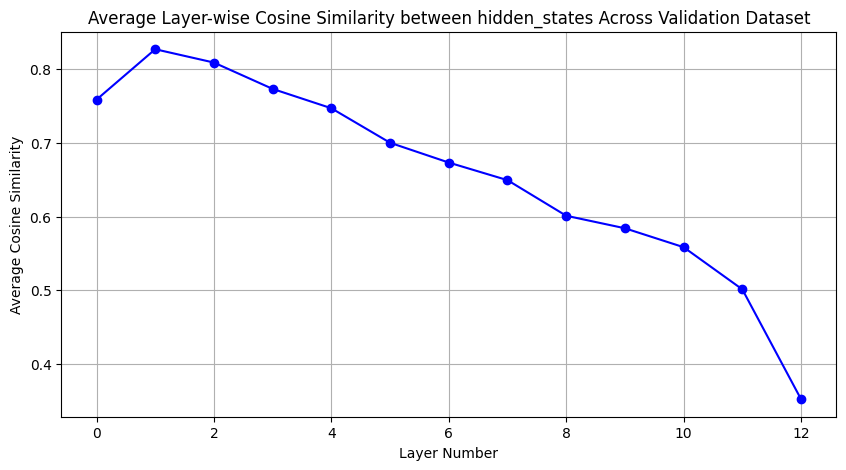

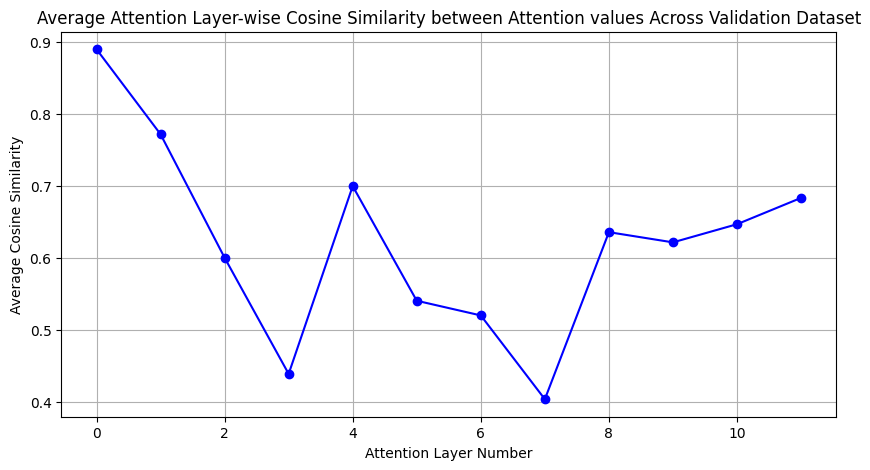

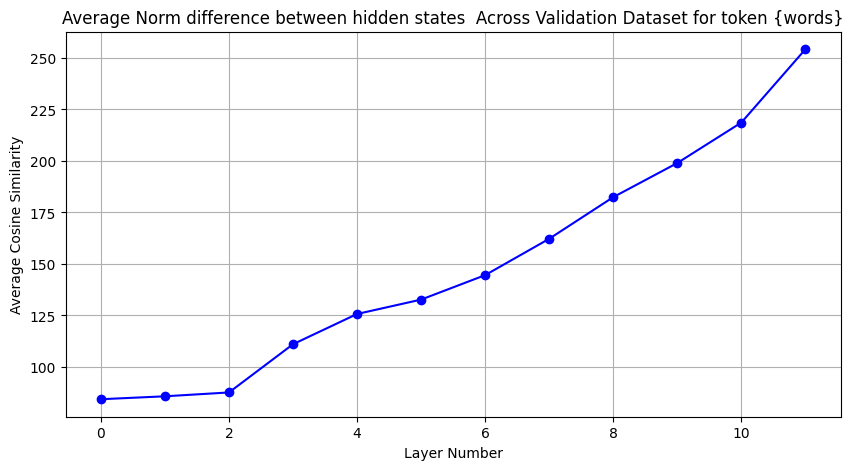

In [58]:

mean_similarities_hidden_states,mean_similarities_attention,diff_tot = comprehension_model.extract_and_compare_activations(model_kb, model_hugging_face, valid_filtered_dataloader,token_id)
print("Layer-wise cosine similarities:", mean_similarities_hidden_states)


plot_results(mean_similarities_hidden_states)
plot_results(mean_similarities_attention,'Attention Layer Number',title='Average Attention Layer-wise Cosine Similarity between Attention values Across Validation Dataset')
plot_results(diff_tot,'Layer Number',title='Average Norm difference between hidden states  Across Validation Dataset for token {words}')



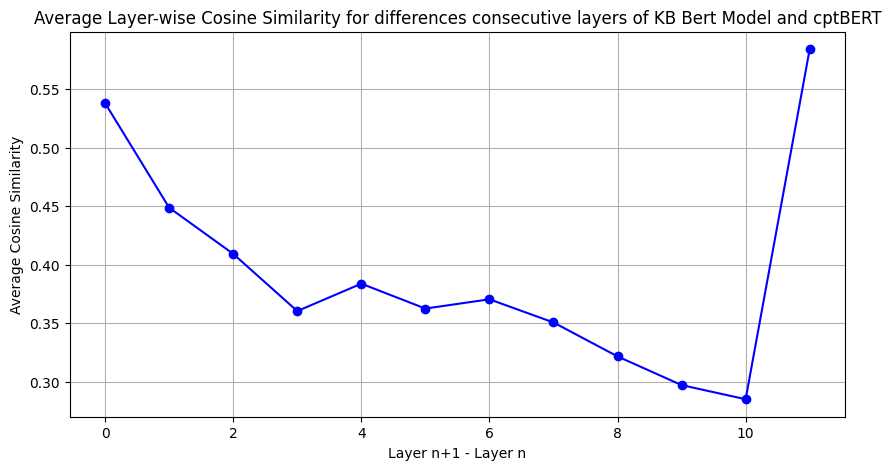

In [61]:
#difference consecutive lauyers

mean_similarity_pr = compare_ffn_contributions_consecutive_layers(model_kb, model_hugging_face, small_valid_dataloader)

plot_results(mean_similarity_pr, x_label='Layer n+1 - Layer n', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity for differences consecutive layers of KB Bert Model and cptBERT')



Weight distribution study

cls.predictions.transform.LayerNorm.weight


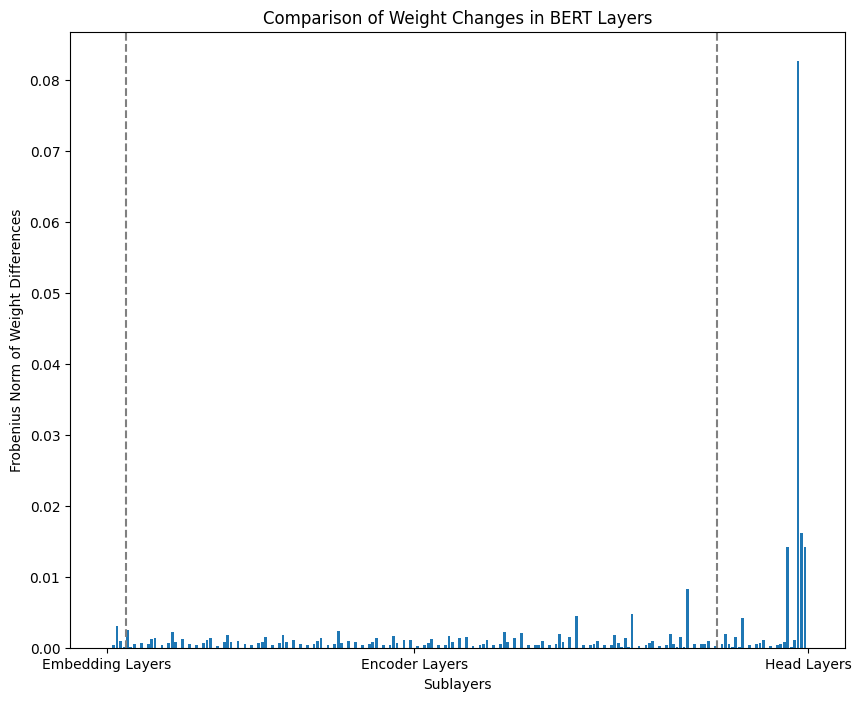

In [ ]:
# Comparaison of weights for different model

weights_kb = comprehension_model.get_model_weights(model_kb)
weights_finetuned = comprehension_model.get_model_weights(model_hugging_face)

weight_diffs = {}
for key in weights_kb.keys():
    weight_diffs[key] = weights_finetuned[key] - weights_kb[key]
    if (np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) > 0.04 :
        print(key)
    #     print(np.linalg.norm(weight_diffs[key],2))
    #     print(weight_diffs[key].size)
    #     print( np.linalg.norm(weight_diffs[key])/weight_diffs[key].size)
    

weight_diffs["cls.predictions.decoder.bias"] = model_hugging_face.cls.predictions.decoder.bias.detach().cpu().numpy() - model_kb.cls.predictions.decoder.bias.detach().cpu().numpy()
weight_diffs["cls.predictions.decoder.weight"] = model_hugging_face.cls.predictions.decoder.weight.detach().cpu().numpy() - model_kb.cls.predictions.decoder.weight.detach().cpu().numpy()
norms = [(np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) for key in weight_diffs.keys()]
embedding_indices = [list(range(0, 5))]
encoder_layers= list(range(5 ,5 +16*(11)))  # Adjust based on actual sublayers
head_layer_indices = list(range(181, len(norms)))

xticks_positions = [0, len(encoder_layers)//2 + len(embedding_indices), len(norms)-1]
xticks_labels = ['Embedding Layers', 'Encoder Layers', 'Head Layers']

plt.figure(figsize=(10, 8))
plt.bar(range(len(norms)), norms)
plt.axvline(x=5.5, color='grey', linestyle='--')
plt.axvline(x=len(embedding_indices) + len(encoder_layers) - 0.5, color='grey', linestyle='--')
plt.xticks(xticks_positions, xticks_labels, rotation=0)
plt.ylabel('Frobenius Norm of Weight Differences')
plt.xlabel('Sublayers')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show()  

In [ ]:
#comaparaison weight change


with PdfPages('weight_distribution_scratch.pdf') as pdf:
    for name,param in mosaicBert.named_parameters():
        layer_name = name
        print(name)
        split_name =name.split('.')
        layer = split_name[3]
        print(layer)
        #comprehension_model.plot_weight_distributions(model_hugging_face, model_kb, layer_name)
        if "attention.self.Wqkv"  in name and "weight" in name:
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.query.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][:768,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.key.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][768:1536,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.value.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][1536:,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
        elif  "attention.self.Wqkv" in name and "bias" in name :
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.query.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][:768].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.key.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][768:1536].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.value.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][1536:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close() 
        elif "mlp.gated_layers"  in name :
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.intermediate.dense.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "mlp.wo" in name :
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.output.dense.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "mlp.layernorm"  in name :
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.output.LayerNorm.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "cls.predictions.decoder" in name:
            continue
            
        else :
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            weights2 = model_kb.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()

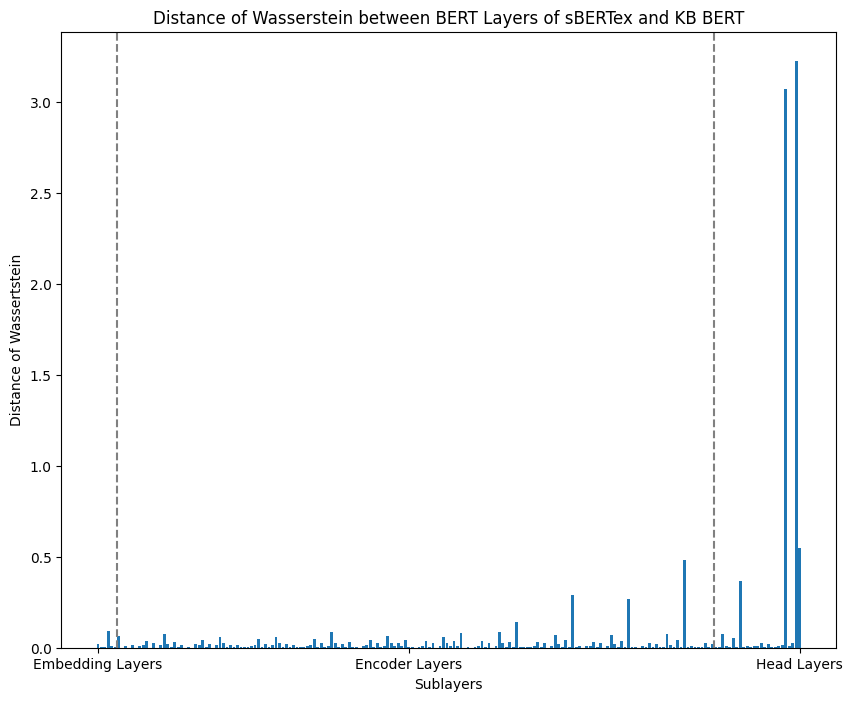

In [46]:
#  Wasserstein distance of weight distribution


params_model_1 = extract_parameters(model_kb)
params_model_2 = extract_parameters(model_exbert)


distances = []
param_names = []

for param_name in params_model_1:
        distance = wasserstein_distance(params_model_1[param_name], params_model_2[param_name])
        distances.append(distance)
        param_names.append(param_name)

# Créer un graphique de la distance de Wasserstein pour chaque paramètre
embedding_indices = [list(range(0, 5))]
encoder_layers= list(range(5 ,5 +16*(11)))  # Adjust based on actual sublayers
head_layer_indices = list(range(181, len(distances)))
xticks_positions = [0, len(encoder_layers)//2 + len(embedding_indices), len(distances)-1]
xticks_labels = ['Embedding Layers', 'Encoder Layers', 'Head Layers']
plt.figure(figsize=(10, 8))
plt.bar(range(len(distances)), distances)
plt.axvline(x=5.5, color='grey', linestyle='--')
plt.axvline(x=len(embedding_indices) + len(encoder_layers) - 0.5, color='grey', linestyle='--')
plt.xticks(xticks_positions, xticks_labels, rotation=0)
plt.ylabel('Distance of Wassertstein')
plt.xlabel('Sublayers')
plt.title('Distance of Wasserstein between BERT Layers of sBERTex and KB BERT')
plt.show()  

Study of intrinseque effect of layer

In [64]:

#Encoder layer

cosine_cpt_final=[]
cosine_eb_final=[]
cosine_spa_final=[]
hidden_states=[]
cosine_embedding=[]
diff_final_kb=[]
diff_final_eb=[]
embedding_cpt = model_hugging_face.bert.embeddings
embedding_kb=model_kb.bert.embeddings

# random_vector = torch.randn_like(hidden_states[0]).to(device)
torch.manual_seed(33)
for layer in range(12):

    cosine_cpt=[]
    cosine_eb=[]
    cosine_spa=[]
    diff_kb=[]
    diff_eb=[]
    last_layer_kb = model_kb.bert.encoder.layer[layer]
    last_layer_cpt = model_hugging_face.bert.encoder.layer[layer]
    last_layer_eb=model_exbert.bert.encoder.layer[layer]
       
    for batch in small_valid_dataloader :
        batch={key:value.to(device) for key,value in batch.items()}
        with torch.no_grad():
            output=model_kb(**batch,output_hidden_states=True)
        if layer ==0:
            embedding = embedding_cpt(batch["input_ids"])
            
        hidden_states=output.hidden_states[layer].to(device)

    
        hs_kb=last_layer_kb(hidden_states)
        hs_cpt=last_layer_cpt(hidden_states)
        hs_eb=last_layer_eb(hidden_states)
        
            
        cosine_cpt.append(cosine_similarity(hs_kb[0],hs_cpt[0]))
        cosine_eb.append(cosine_similarity(hs_kb[0],hs_eb[0]))
        cosine_spa.append(cosine_similarity(hs_eb[0],hs_cpt[0]))
        diff_kb.append(cosine_similarity(hs_kb[0]-hidden_states,hs_cpt[0]-hidden_states))
        diff_eb.append(cosine_similarity(hs_kb[0]-hidden_states,hs_eb[0]-hidden_states))

    cosine_cpt_final.append(np.mean(cosine_cpt))
    cosine_eb_final.append(np.mean(cosine_eb))
    cosine_spa_final.append(np.mean(cosine_spa,axis=0))
    diff_final_kb.append(np.mean(diff_kb))
    diff_final_eb.append(np.mean(diff_eb))
    
    print(np.mean(cosine_cpt))
    print(np.mean(cosine_eb))   
            

plot_results(cosine_cpt_final,x_label='Layer',title='Avg cosine similarity between KB bert and cptBERT without propagation')
plot_results(cosine_eb_final,x_label='Layer',title='Avg cosine similarity between KB bert and sBERTex without propagation')
plot_results(cosine_spa_final,x_label='Layer',title='Avg cosine similarity between cptBERT and sBERTex without propagation')
plot_results(diff_final_kb,x_label='Layer',title='Avg cosine similarity between differences of consecutives layers cptBERT and KB bert without propagation')
plot_results(diff_final_eb,x_label='Layer',title='Avg cosine similarity between differences of consecutives layers sBERTex and KB bert without propagation')


0.9046910443123738
0.8917356737100395
0.9276974679558141
0.9111939729398982
0.9304040526128878
0.9118857729207178
0.9387525551638026
0.9236147798550357
0.9448630938864058
0.9287621754749565
0.9388637493370445
0.9212276202857874
0.938719470789478
0.920568309012492
0.9421228667733016
0.9277260052930018
0.9543434423246201
0.9433020657035196
0.9553514255839548
0.9446461720831075
0.9629793702417119
0.9569506178236311


KeyboardInterrupt: 

In [ ]:
#Head layers

text="Herr [MASK] von Ehrenheim : Anledningen till den framställning"
input_kb=tokenizer(text,return_tensors='pt').to(device)
output=model_kb(**input_kb,output_hidden_states=True)

hidden_states=output.hidden_states[-1].to(device)
head_layer_kb=model_kb.cls
head_layer_cpt=model_hugging_face.cls
head_layer_eb=model_exbert.cls
head_layer_spa=mosaicBert.cls
output_kb = head_layer_kb(hidden_states)
output_cpt = head_layer_cpt(hidden_states)
output_eb = head_layer_eb(hidden_states)
output_spa=head_layer_spa(hidden_states)
print(output_kb.shape)

softmax_probs_kb = F.softmax(output_kb.squeeze()[2], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
print(sorted_tokens_kb)

softmax_probs_kb = F.softmax(output.logits.squeeze()[2], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
print(sorted_tokens_kb)

softmax_probs_cpt = F.softmax(output_cpt.squeeze()[2], dim=-1)
sorted_probs_cpt, sorted_indices_cpt = torch.sort(softmax_probs_cpt, descending=True)
sorted_tokens_cpt= [tokenizer.decode([idx]) for idx in sorted_indices_cpt[:10]]
print(sorted_tokens_cpt)

softmax_probs_eb = F.softmax(output_eb.squeeze()[2], dim=-1)
sorted_probs_eb, sorted_indices_eb = torch.sort(softmax_probs_eb, descending=True)
sorted_tokens_eb = [exbert_tokenizer.decode([idx]) for idx in sorted_indices_eb[:10]]
print(sorted_tokens_eb)


softmax_probs_spa = F.softmax(output_spa.squeeze()[2], dim=-1)
sorted_probs_spa, sorted_indices_spa = torch.sort(softmax_probs_spa, descending=True)
sorted_tokens_spa = [swerick_tokenizer.decode([idx]) for idx in sorted_indices_spa[:10]]
print(sorted_tokens_spa)

Edge Probing

In [73]:
#Dataset for spelling reform
data_files = {"train":"swerick_subsetdata_party_train.csv","test": "swerick_subsetdata_party_test.csv"}
date_dataset=load_dataset("csv",data_files=data_files)
date_dataset["train"] = date_dataset["train"].shuffle(seed=42)


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [83]:

data_collator = default_data_collator
encoded_dataset_train_cpt=Dataset.from_dict(date_dataset["train"][:1000]).map(lambda example :extract_features(example,model_hugging_face,tokenizer), batched=False)
encoded_dataset_train_kb=Dataset.from_dict(date_dataset["train"][:1000]).map(lambda example :extract_features(example,model_kb,tokenizer), batched=False)
encoded_dataset_train_eb=Dataset.from_dict(date_dataset["train"][:1000]).map(lambda example :extract_features(example,model_exbert,exbert_tokenizer), batched=False)
encoded_dataset_test_cpt = Dataset.from_dict(date_dataset["test"][:1000]).map(lambda example :extract_features(example,model_hugging_face,tokenizer), batched=False)
encoded_dataset_test_kb = Dataset.from_dict(date_dataset["test"][:1000]).map(lambda example :extract_features(example,model_kb,tokenizer), batched=False)
encoded_dataset_test_eb = Dataset.from_dict(date_dataset["test"][:1000]).map(lambda example :extract_features(example,model_exbert,exbert_tokenizer), batched=False)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [84]:

scores_cpt = scores_linear_prob(encoded_dataset_train_cpt,encoded_dataset_test_cpt)
scores_kb = scores_linear_prob(encoded_dataset_train_kb,encoded_dataset_test_kb)
scores_eb = scores_linear_prob(encoded_dataset_train_eb,encoded_dataset_test_eb)


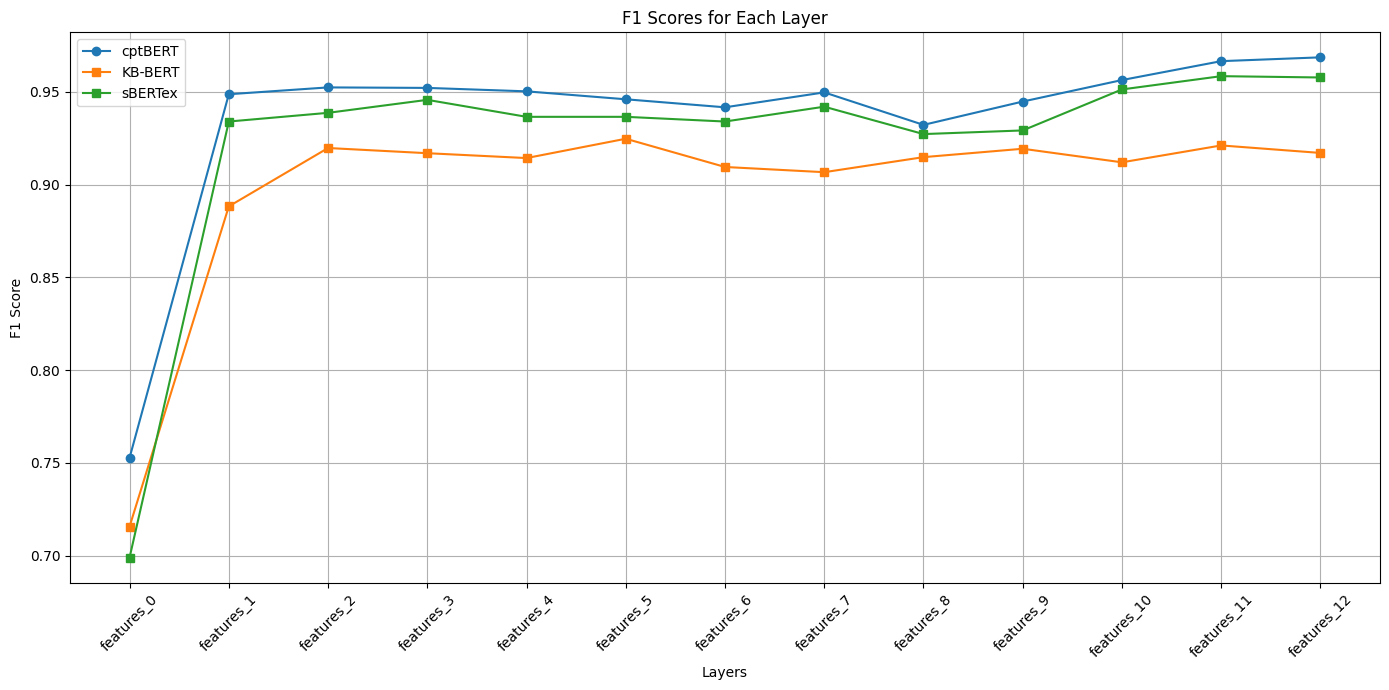

In [85]:
layers = list(scores_cpt.keys())

test_scores_1 = [scores_cpt[layer][1] for layer in layers]
test_scores_2 = [scores_kb[layer][1] for layer in layers]
test_scores_3 = [scores_eb[layer][1] for layer in layers]

plt.figure(figsize=(14, 7))


plt.plot(layers, test_scores_1, label='cptBERT', marker='o')
plt.plot(layers, test_scores_2, label='KB-BERT', marker='s')
plt.plot(layers, test_scores_3, label='sBERTex', marker='s')


plt.xlabel('Layers')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Each Layer')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout()
plt.show()

Scalar Mixing

In [86]:
class Config:
    def __init__(self, bert_version, tokenizer):
        self.data_path_train = 'swerick_subsetdata_party_train.csv'
        self.data_path_test = 'swerick_subsetdata_party_test.csv'
        self.data_path_valid = 'swerick_subsetdata_party_test.csv'
        self.bert_version = bert_version
        self.tokenizer = tokenizer
        self.batch_size = 32
        self.epochs = 3
        self.hidden_size = 768
        self.learning_rate = 2e-5
        self.optimizer = 'adam'
        self.seed = 42
    
    
from evaluation.probing_experiments import GridLocProbeExperiment
config_kb = Config("KBLab/bert-base-swedish-cased","KBLab/bert-base-swedish-cased")
config_cpt = Config("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500","KBLab/bert-base-swedish-cased")
experiment_kb = GridLocProbeExperiment(config_kb)
experiment_cpt = GridLocProbeExperiment(config_cpt)
config_eb = Config("exbert-finetuned-imdb/checkpoint-6054000","exbert_tokenizer")
experiment_eb= GridLocProbeExperiment(config_eb)

Some weights of BertModel were not initialized from the model checkpoint at finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of BertModel were not initialized from the model checkpoint at exbert-finetuned-imdb/checkpoint-6054000 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [87]:
F1_kb,diff_kb =experiment_kb.cumulative_probe()
F1_cpt,diff_cpt =experiment_cpt.cumulative_probe()
F1_eb,diff_eb =experiment_eb.cumulative_probe()

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0',
       requires_grad=True)


 53%|█████▎    | 17/32 [00:03<00:02,  5.03it/s]


KeyboardInterrupt: 

/tmp/ipykernel_809095/51561001.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights_eb_bis=torch.nn.functional.softmax(torch.tensor([-0.0017, -0.0017, -0.0015,  0.0019, -0.0006,  0.0018,  0.0017,  0.0017,


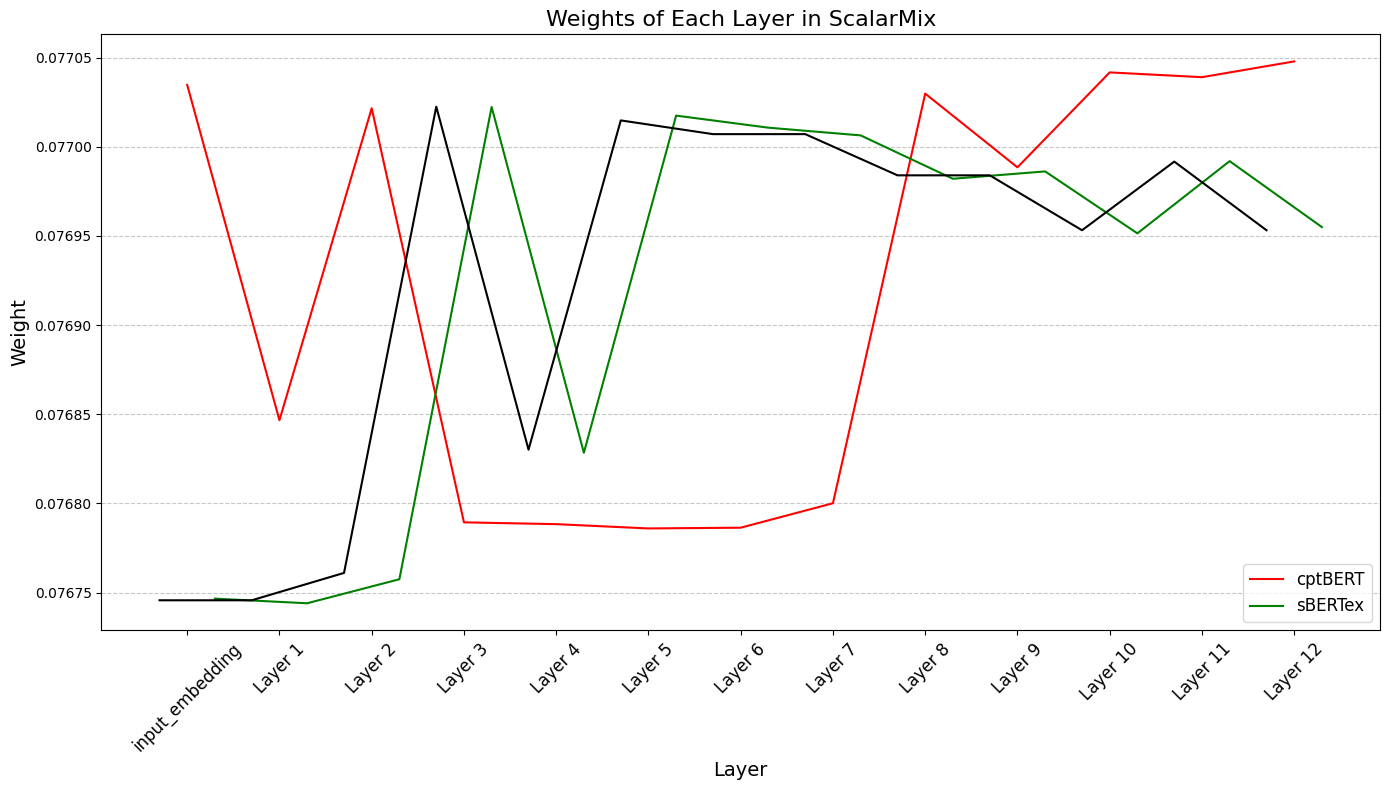

In [ ]:

weights_kb = torch.nn.functional.softmax(experiment_kb.model.weights.detach(), dim=0).cpu().numpy()
weights_cpt = torch.nn.functional.softmax(experiment_cpt.model.weights.detach(), dim=0).cpu().numpy()
weights_eb = torch.nn.functional.softmax(experiment_eb.model.weights.detach(), dim=0).cpu().numpy()

num_layers = len(weights_kb)
bar_width = 0.3
positions_kb = np.arange(num_layers)
positions_cpt = positions_kb + bar_width
positions_eb = positions_cpt + bar_width


plt.figure(figsize=(14, 8))
bars_kb = plt.plot(positions_kb, weights_kb, color='skyblue', label='KBBERT')
bars_cpt = plt.plot(positions_cpt, weights_cpt,color='red', label='cptBERT')
bars_eb = plt.plot(positions_eb, weights_eb, color='green', label='sBERTex')

# Add labels and title
plt.xlabel('Layer', fontsize=14)
plt.ylabel('Weight', fontsize=14)
plt.title('Weights of Each Layer in ScalarMix', fontsize=16)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

layer_labels = ['input_embedding'] + [f'Layer {i}' for i in range(1, num_layers)]
plt.xticks(positions_kb + bar_width, labels=layer_labels, fontsize=12,rotation=45)

# Show the plot
plt.tight_layout()
plt.show()
